In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os,sys
import re
import math
from datetime import datetime
import time
sys.dont_write_bytecode = True

In [3]:
import pandas as pd

import numpy as np
import joblib
import matplotlib.pyplot as plt

from pathlib import Path
from typing import Any, List, Set, Dict, Tuple, Optional, Iterable, Mapping, Union, Callable, TypeVar

from pprint import pprint
from ipdb import set_trace as brpt

In [4]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from  torch.linalg import norm as tnorm
from torch.utils.data import Dataset, DataLoader, random_split

from torchvision import datasets, transforms

import pytorch_lightning as pl
from pytorch_lightning.core.lightning import LightningModule
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.tuner.tuning import Tuner


# Select Visible GPU
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"]="1"

## Set Path 
1. Add project root and src folders to `sys.path`
2. Set DATA_ROOT to `maptile_v2` folder

In [5]:
this_nb_path = Path(os.getcwd())
ROOT = this_nb_path.parent
SRC = ROOT/'src'
DATA_ROOT = Path("/data/hayley-old/maptiles_v2/")
paths2add = [this_nb_path, ROOT]

print("Project root: ", str(ROOT))
print('Src folder: ', str(SRC))
print("This nb path: ", str(this_nb_path))


for p in paths2add:
    if str(p) not in sys.path:
        sys.path.insert(0, str(p))
        print(f"\n{str(p)} added to the path.")
# print(sys.path)

Project root:  /data/hayley-old/Tenanbaum2000
Src folder:  /data/hayley-old/Tenanbaum2000/src
This nb path:  /data/hayley-old/Tenanbaum2000/nbs

/data/hayley-old/Tenanbaum2000 added to the path.


In [6]:
from src.data.datamodules.maptiles_datamodule import MaptilesDataModule

from src.data.transforms.transforms import Identity, Unnormalizer, LinearRescaler, Monochromizer
from src.data.transforms.functional import unnormalize, to_monochrome

from src.visualize.utils import show_timg, show_timgs, show_batch, make_grid_from_tensors
from src.utils.misc import info
from collections import OrderedDict, defaultdict
from PIL import Image

# Rotated MNIST dataset
Jan 22, 2021

Equivalent to MonoMNIST, but with rotation angle as the "domain" / style.


In [21]:
class RotatedMNIST(Dataset):
    
    _fn_formatspec = "{mode}_mnist_{angle}"
    _keys = ['img', 'digit', 'angle']
    
    
    def __init__(
        self,
        data_root: Path,
        angle: float, #counter-clockwise
        transform: Optional[Callable] = None,
        digit_label_transform: Optional[Callable] = None, 
        angle_label_transform: Optional[Callable] = None,
        download: bool = True,
        train: bool = True
    ):
        super().__init__()
        self.data_root = Path(data_root)
        self.angle = angle
        
        self.transform = transforms.Compose([transforms.ToTensor(),
                                             TF.rotate(self.angle)])
        # If transform is given, append it to the base transform above
        if transform is not None:
            self.transform = transforms.Compose([self.transform, transform])
        self.digit_label_transform = digit_label_transform #input is int
        self.angle_label_transform = angle_label_transform # input is float
        
        self.download = download
        self.train = train
        self.mode = 'train' if self.train else 'test'

        self.data, self.digit_labels = get_mnist_data(self.train, self.download)
        
    def __getitem__(self, index: int) -> Dict[str, Union[torch.Tensor, int, float]]:
        """Returns a sample of type Dict with keys:
        sample['img'] : torch.Tensor of a single image
        sample['digit'] : int in [0, ..., 9]
        sample['angle'] : float 
            self.angle for any item
        """
        img, digit_label = self.data[index], int(self.digit_labels[index])
        angle_label = self.angle
        # img is a PIL image of mode L, shape (28,28)
        
        if self.transform is not None:
            img = self.transform(img)
        if self.digit_label_transform is not None:
            digit_label = self.digit_label_transform(digit_label)
        if self.angle_label_transform is not None:
            angle_label = self.angle_label_transform(angle_label) # may be used for encoding domain label when used with other angles dataset
        
        return {"img": img,
               "digit": digit_label,
               "angle": angle_label}
    
    
    def __len__(self) -> int:
        return len(self.data)
            
    @property
    def name(self) -> str:
        return self._fn_formatspec.format(mode=self.mode, angle=self.angle)
    
    

In [38]:
from PIL.Image import Image

In [39]:
def get_mnist_data(use_train_dataset: bool=True, 
                   download=True
                  ) -> Tuple[List[Image], List[int]]:
    # Get all imgs and digits in MNIST dataset
    ds = datasets.MNIST(mnist_data_root, train=use_train_dataset, download=download)

    pil_imgs = []
    digit_labels = []
    for i in range(len(ds)):
        x,y = ds[i]
        pil_imgs.append(x)
        digit_labels.append(y)
    return pil_imgs, digit_labels

        

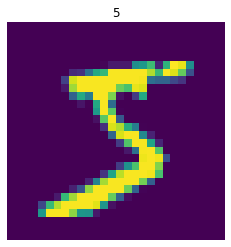

In [47]:
def test_get_mnist_data():
    mnist_data_root = Path('/data/hayley-old/Tenanbaum2000/data')
    pils, digits = get_mnist_data(True, True)
    plt.imshow(pils[0])
    plt.title(digits[0])
    plt.axis('off')
# test_get_mnist_data()


In [41]:
len(pil_imgs)

60000

In [42]:
len(digit_labels)

60000

In [43]:
digit_labels[0]

5

In [44]:
pil_imgs[0]

In [10]:
x.width, x.height

(28, 28)

In [11]:
import torchvision.transforms.functional as TF


In [14]:
t = transforms.ToTensor()(x)
info(t)

shape:  torch.Size([1, 28, 28])
dtype:  torch.float32
min, max:  0.0 1.0


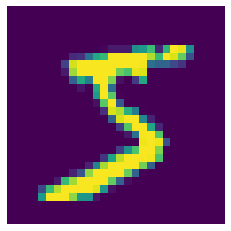

In [15]:
show_timg(t)

shape:  torch.Size([1, 28, 28])
dtype:  torch.float32
min, max:  0.0 1.0


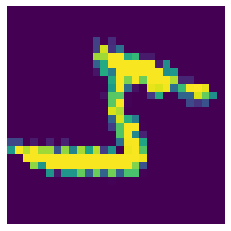

In [22]:
t_rotated = TF.rotate(t, -30)
show_timg(t_rotated)
info(t_rotated)

## Test rotated mnist dataset class

In [57]:
from src.data.datasets.rotated_mnist import RotatedMNIST

In [64]:
ds_30 = RotatedMNIST(mnist_data_root, 30)
ds_45 = RotatedMNIST(mnist_data_root, 45)
ds_0 = RotatedMNIST(mnist_data_root, 0)
ds_n30 = RotatedMNIST(mnist_data_root, -30)
ds_n45 = RotatedMNIST(mnist_data_root, -45)

angle:  0


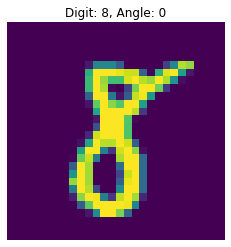

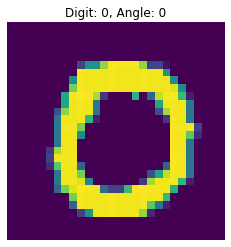

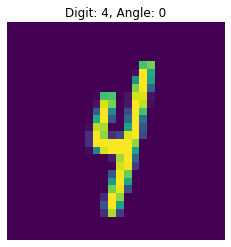

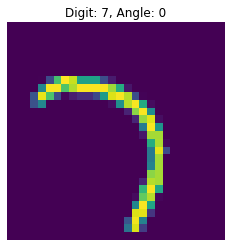

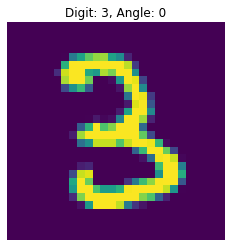

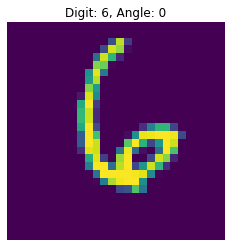

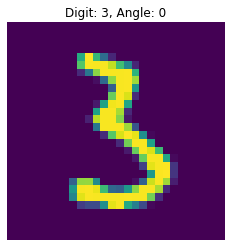

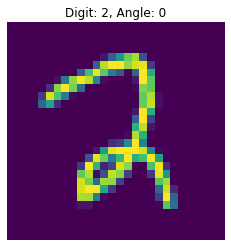

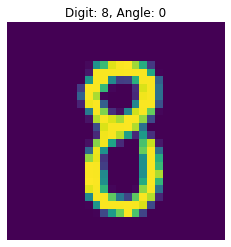

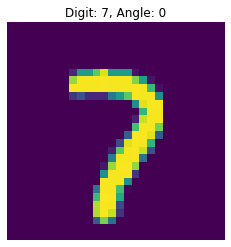

In [66]:
ds = ds_0
print("angle: ", ds_0.angle)

for i in range(10):
    ind = np.random.choice(len(ds))
    sample = ds[ind]
    x, y, d = ds.unpack(sample)
    show_timg(x)
    plt.title(f"Digit: {y}, Angle: {d}")


In [ ]:
angles = [45, 30, 0, -30, -45]
dsets = {}
for angle in angles:
    dsets[str(angle)] = RotatedMNIST(mnist_data_root, angle)
    

angle:  45 45
angle:  30 30
angle:  0 0
angle:  -30 -30
angle:  -45 -45


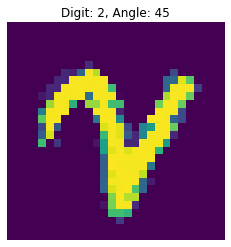

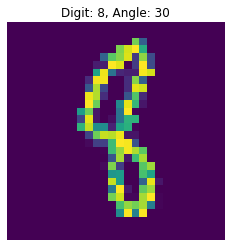

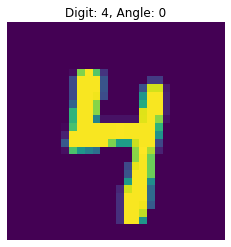

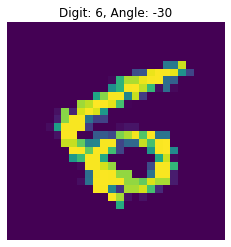

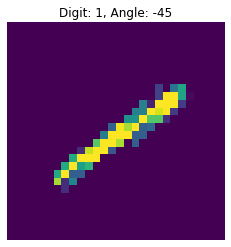

In [68]:
for angle_str, dset in dsets.items():
    print("angle: ", angle_str, dset.angle)
    ind = np.random.choice(len(dset))
    sample = dset[ind]
    x, y, d = dset.unpack(sample)
    show_timg(x)
    plt.title(f"Digit: {y}, Angle: {d}")
    